In [99]:
import sys
import os
# Add the scripts directory to the sys.path
scripts_path = os.path.abspath('../scripts')
sys.path.append(scripts_path)
import data_preprocessing as dp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import plot_tree
import seaborn as sns


In [101]:
df = dp.load_and_preprocess_data('../data/lung_cancer.csv')

In [103]:
# Split into features (X) and target (y)
X = df.drop('LUNG CANCER', axis=1)
y = df['LUNG CANCER']  # Target class

# Train test splitt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE and scaler
smote = SMOTE(random_state=42)
scaler = StandardScaler()

# Model Hyperparameters

In [106]:
# Decision Tree config
param_grid_dt = {
    'max_depth': [3, 4, 5, 6, 7, 10, 15, None],    # max depth of each tree
    'min_samples_split': [2, 3, 4, 5, 10],         # min required to split a node
    'min_samples_leaf': [1, 2, 3, 4, 5],           # min samples required at leaf node
    'criterion': ['gini', 'entropy']
}

# random Forest model config
param_grid_rf = {
    'n_estimators': [50, 100, 200],     # number of trees in forest
    'max_depth': [None, 3, 4, 5, 6, 7, 10, 15],        
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],         
    'criterion': ['gini', 'entropy']       
}

# logistic Regression config
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100, 250, 500],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# support vector machine condfig
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Add KNN model configuration
param_grid_knn = {
    'n_neighbors': [3, 5, 6, 7, 9, 11],   # number of neighbors to consider
    'weights': ['uniform', 'distance'], # weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'] # distance metric
}

In [108]:
# dictionary to store results
results = {}

def run_model(model, param_grid, model_name, use_smote=False, scale_age=False):
    X_train_processed = X_train.copy()
    y_train_processed = y_train.copy()
    if scale_age and 'AGE' in X_train.columns:
        X_train_processed['AGE'] = scaler.fit_transform(X_train[['AGE']])
        X_test_scaled = X_test.copy()
        X_test_scaled['AGE'] = scaler.transform(X_test[['AGE']])
    else:
        X_test_scaled = X_test
    
    # Apply SMOTE if specified
    if use_smote:
        X_train_processed, y_train_processed = smote.fit_resample(X_train_processed, y_train_processed)

    # Perform Grid Search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_processed, y_train_processed)
    
    # get best model and predictions for that model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # store for later use (display in tabkle later)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label= 1)
    recall = recall_score(y_test, y_pred, pos_label= 1)
    f1 = f1_score(y_test, y_pred, pos_label= 1)
    
    # Save results
    key = f"{model_name} {'with SMOTE' if use_smote else 'without SMOTE'}"
    results[key] = {
        'model': best_model,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    # print results for model
    print(f"\nBest Parameters for {key}:", grid_search.best_params_)
    print(f"Accuracy for {key}:", results[key]['accuracy'])
    print("\nClassification Report:\n", results[key]['classification_report'])
    print("\nConfusion Matrix:\n", results[key]['conf_matrix'])

# Running Models 

In [111]:
# Run Decision Tree models and save the best models
print("=== Decision Tree Models ===")
run_model(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree", use_smote=False)
best_dt_model_without_smote = results["Decision Tree without SMOTE"]['model']

run_model(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree", use_smote=True)
best_dt_model_with_smote = results["Decision Tree with SMOTE"]['model']

=== Decision Tree Models ===
Fitting 5 folds for each of 400 candidates, totalling 2000 fits

Best Parameters for Decision Tree without SMOTE: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
Accuracy for Decision Tree without SMOTE: 0.8928571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.93      0.93      0.93        44

    accuracy                           0.89        56
   macro avg       0.84      0.84      0.84        56
weighted avg       0.89      0.89      0.89        56


Confusion Matrix:
 [[ 9  3]
 [ 3 41]]
Fitting 5 folds for each of 400 candidates, totalling 2000 fits

Best Parameters for Decision Tree with SMOTE: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy for Decision Tree with SMOTE: 0.875

Classification Report:
               precision    recall  f1-score   suppo

In [112]:
# Run Random Forest models and save the best models
print("\n=== Random Forest Models ===")
run_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest", use_smote=False)
best_rf_model_without_smote = results["Random Forest without SMOTE"]['model']

run_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest", use_smote=True)
best_rf_model_with_smote = results["Random Forest with SMOTE"]['model']


=== Random Forest Models ===
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best Parameters for Random Forest without SMOTE: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for Random Forest without SMOTE: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       0.86      1.00      0.93        44

    accuracy                           0.88        56
   macro avg       0.93      0.71      0.76        56
weighted avg       0.89      0.88      0.85        56


Confusion Matrix:
 [[ 5  7]
 [ 0 44]]
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best Parameters for Random Forest with SMOTE: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for Random Forest with SMOTE: 0.9464285714285714

Classification Report:
          

In [113]:
print("\n=== Logistic Regression Models ===")
run_model(LogisticRegression(random_state=42), param_grid_lr, "Logistic Regression", use_smote=False, scale_age=True)
run_model(LogisticRegression(random_state=42), param_grid_lr, "Logistic Regression", use_smote=True, scale_age=True)


=== Logistic Regression Models ===
Fitting 5 folds for each of 63 candidates, totalling 315 fits

Best Parameters for Logistic Regression without SMOTE: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy for Logistic Regression without SMOTE: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.92      1.00      0.96        44

    accuracy                           0.93        56
   macro avg       0.96      0.83      0.88        56
weighted avg       0.93      0.93      0.92        56


Confusion Matrix:
 [[ 8  4]
 [ 0 44]]
Fitting 5 folds for each of 63 candidates, totalling 315 fits

Best Parameters for Logistic Regression with SMOTE: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Accuracy for Logistic Regression with SMOTE: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75    

In [114]:
print("\n=== SVM Models ===")
run_model(SVC(random_state=42), param_grid_svc, "SVM", use_smote=False, scale_age=True)
run_model(SVC(random_state=42), param_grid_svc, "SVM", use_smote=True, scale_age=True)


=== SVM Models ===
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters for SVM without SMOTE: {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
Accuracy for SVM without SMOTE: 0.9107142857142857

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.90      1.00      0.95        44

    accuracy                           0.91        56
   macro avg       0.95      0.79      0.84        56
weighted avg       0.92      0.91      0.90        56


Confusion Matrix:
 [[ 7  5]
 [ 0 44]]
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters for SVM with SMOTE: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for SVM with SMOTE: 0.9464285714285714

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.96      0.98      0.97        44

    accu

In [115]:
print("\n=== KNN Models ===")
run_model(KNeighborsClassifier(), param_grid_knn, "KNN", use_smote=False, scale_age=True)
run_model(KNeighborsClassifier(), param_grid_knn, "KNN", use_smote=True, scale_age=True)


=== KNN Models ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for KNN without SMOTE: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'uniform'}
Accuracy for KNN without SMOTE: 0.9107142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.93      0.95      0.94        44

    accuracy                           0.91        56
   macro avg       0.88      0.85      0.86        56
weighted avg       0.91      0.91      0.91        56


Confusion Matrix:
 [[ 9  3]
 [ 2 42]]
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for KNN with SMOTE: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy for KNN with SMOTE: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.98    

# Visualizations

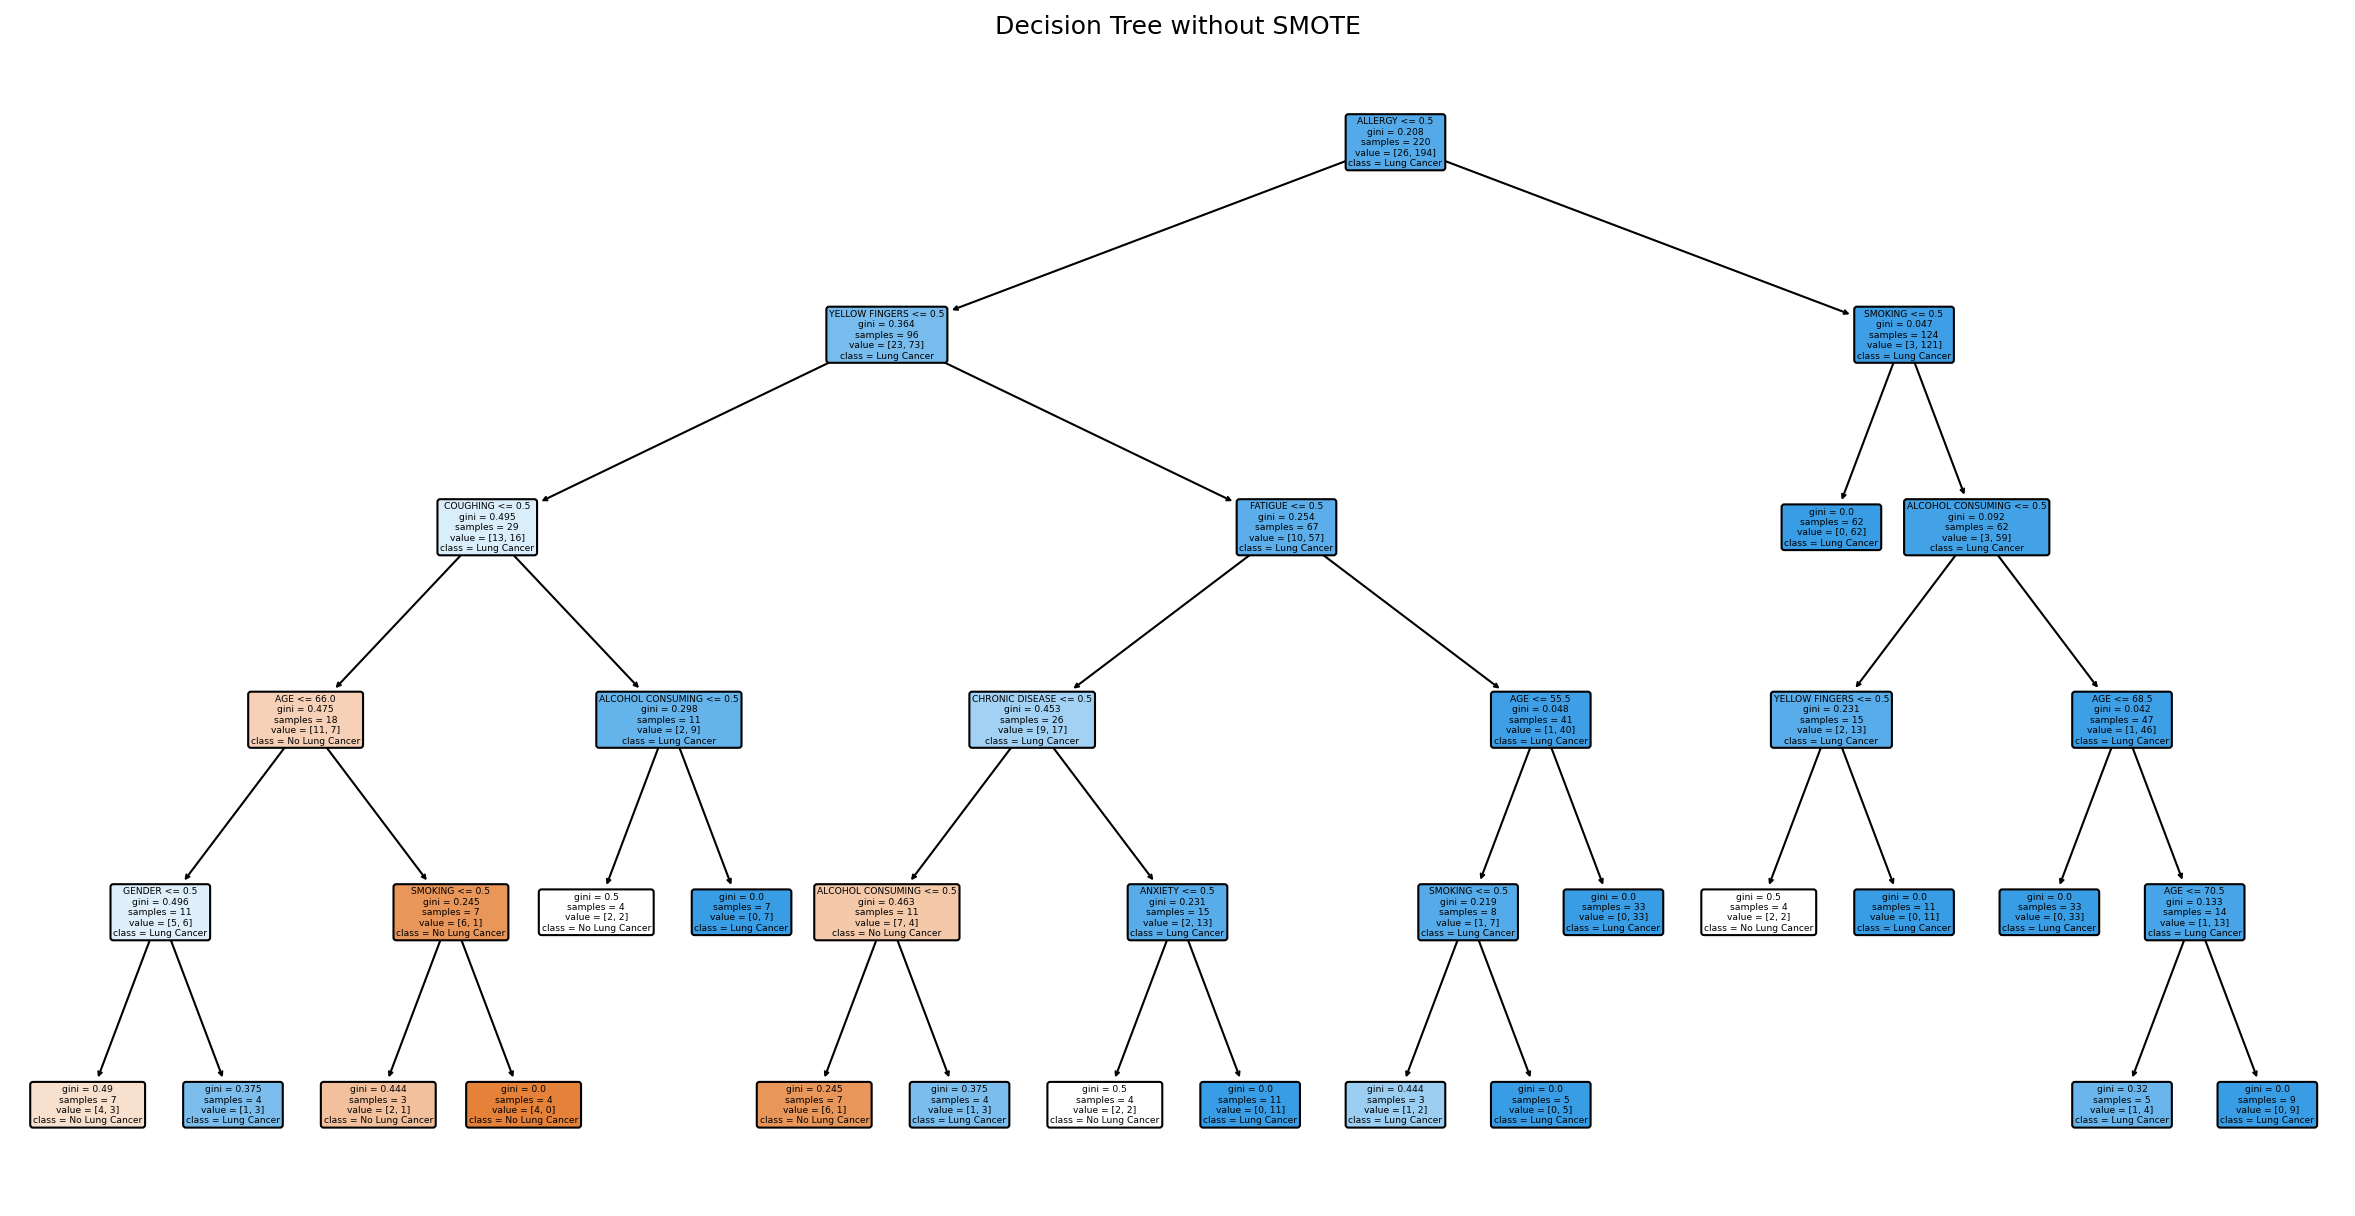

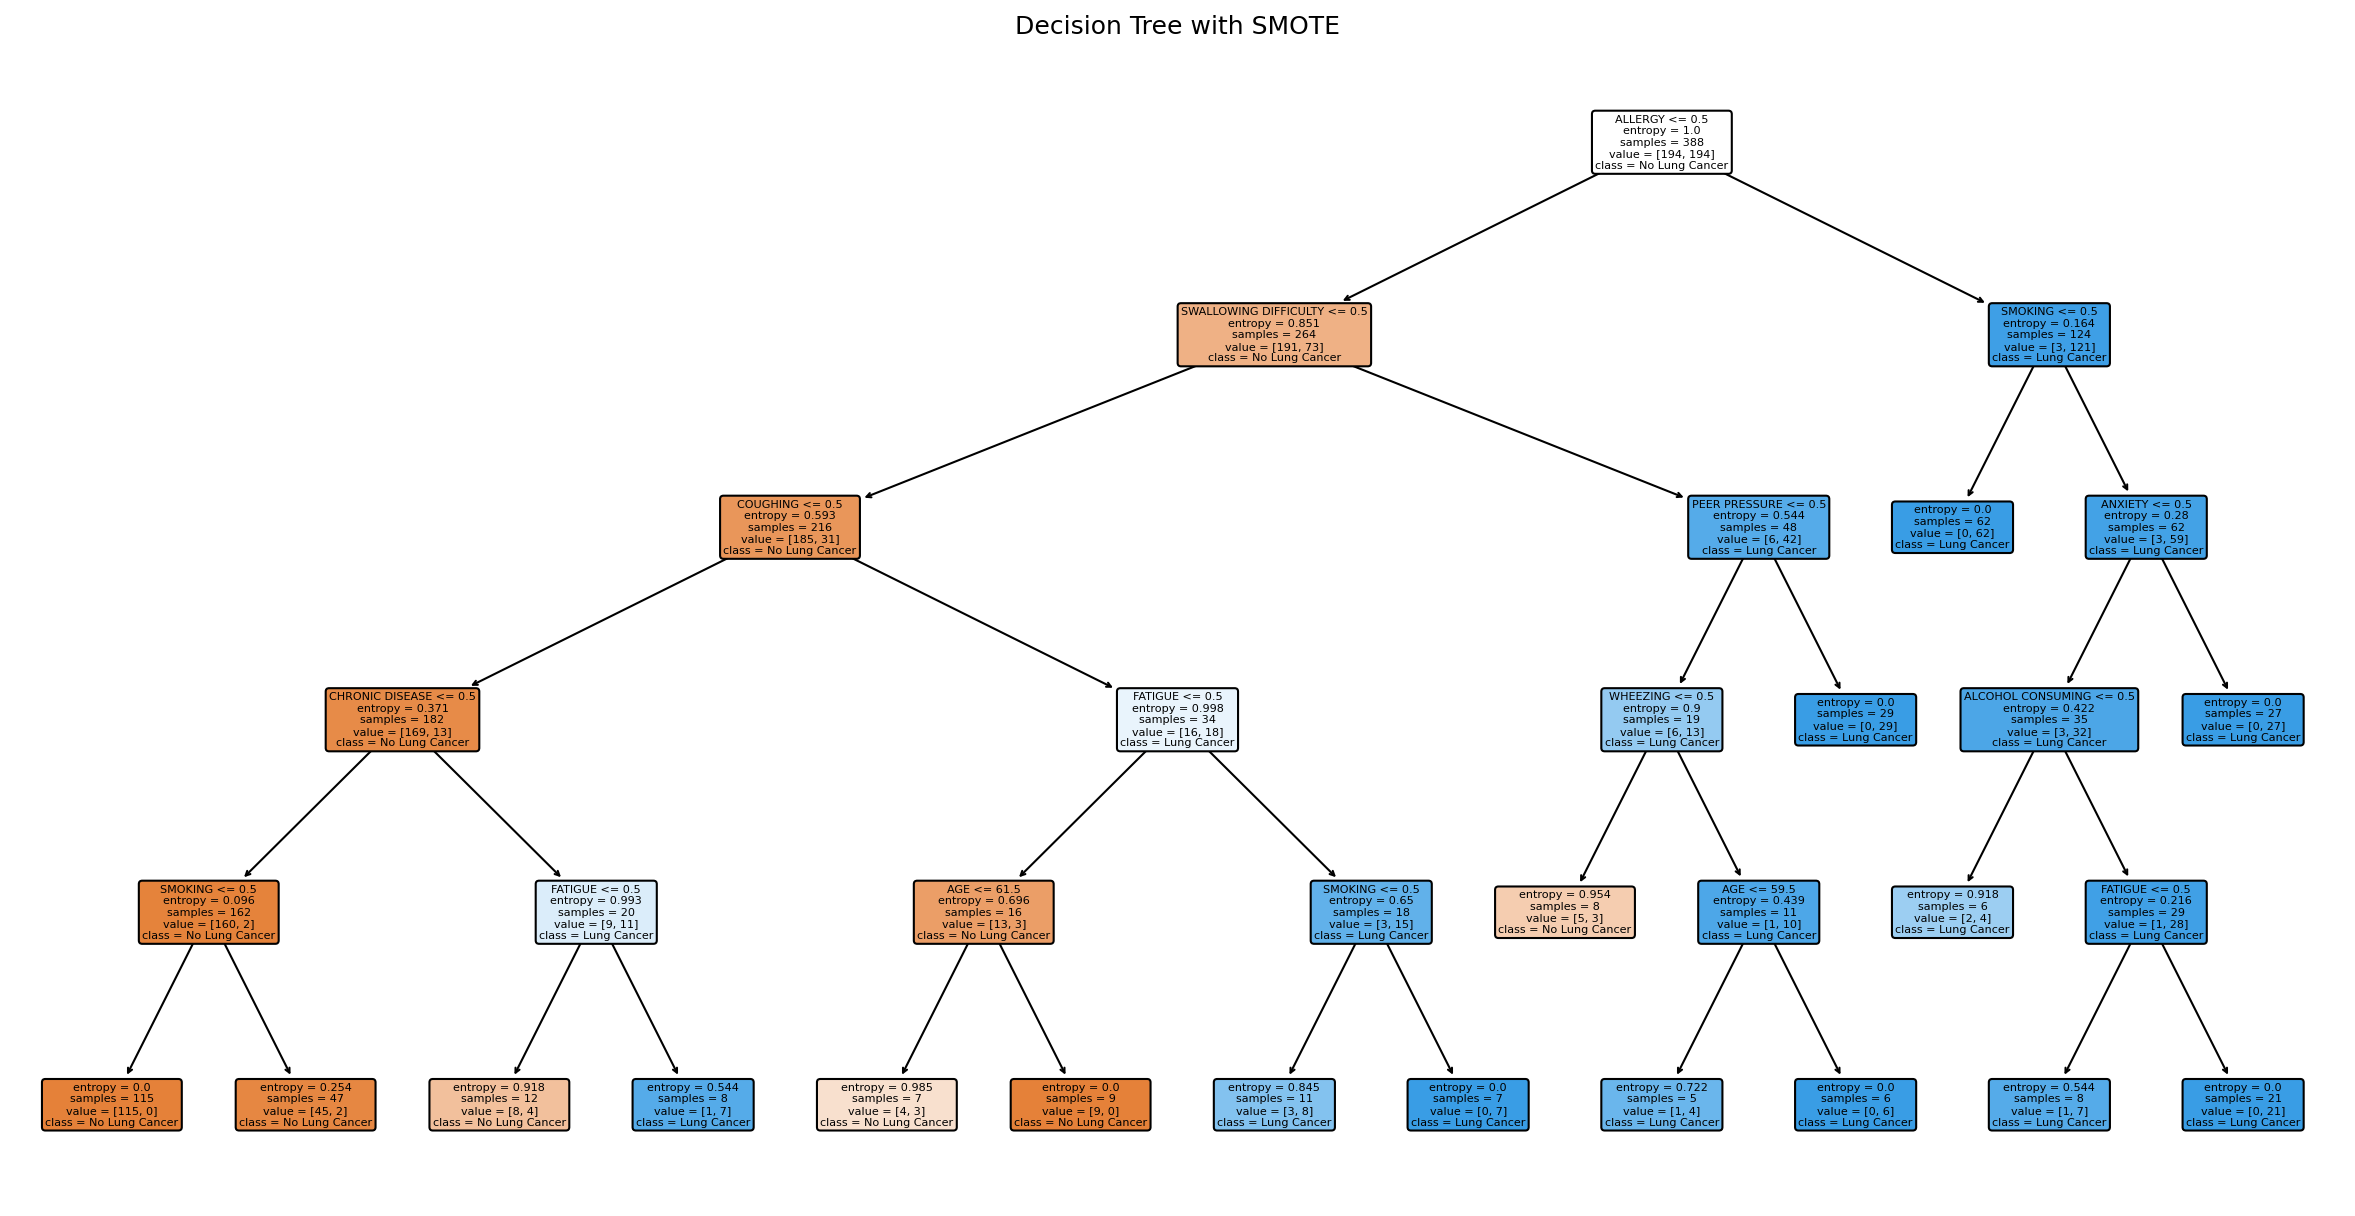

In [118]:
def plot_decision_tree(tree_model, feature_names, class_names, title):
    plt.figure(figsize=(20, 10), dpi=150)
    plot_tree(tree_model, 
              feature_names=feature_names, 
              class_names=class_names, 
              filled=True, 
              rounded=True)
    plt.title(title)
    plt.show()

# Plot the best decision tree models (without and with SMOTE)
plot_decision_tree(best_dt_model_without_smote, X.columns, ['No Lung Cancer', 'Lung Cancer'], title="Decision Tree without SMOTE")
plot_decision_tree(best_dt_model_with_smote, X.columns, ['No Lung Cancer', 'Lung Cancer'], title="Decision Tree with SMOTE")

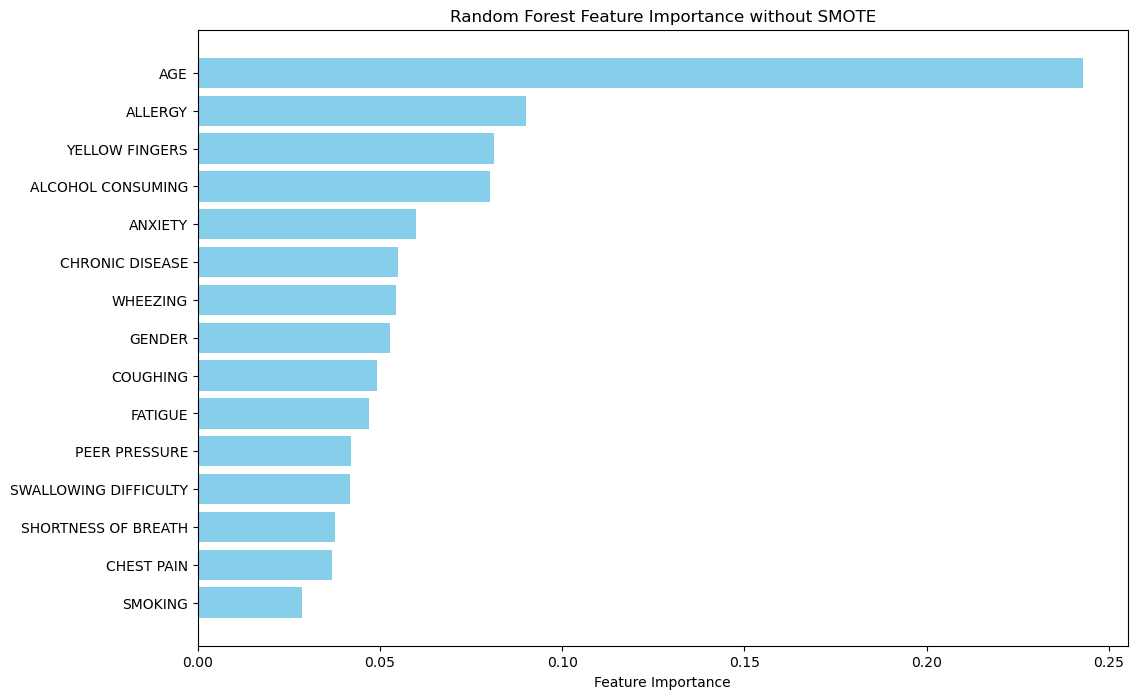

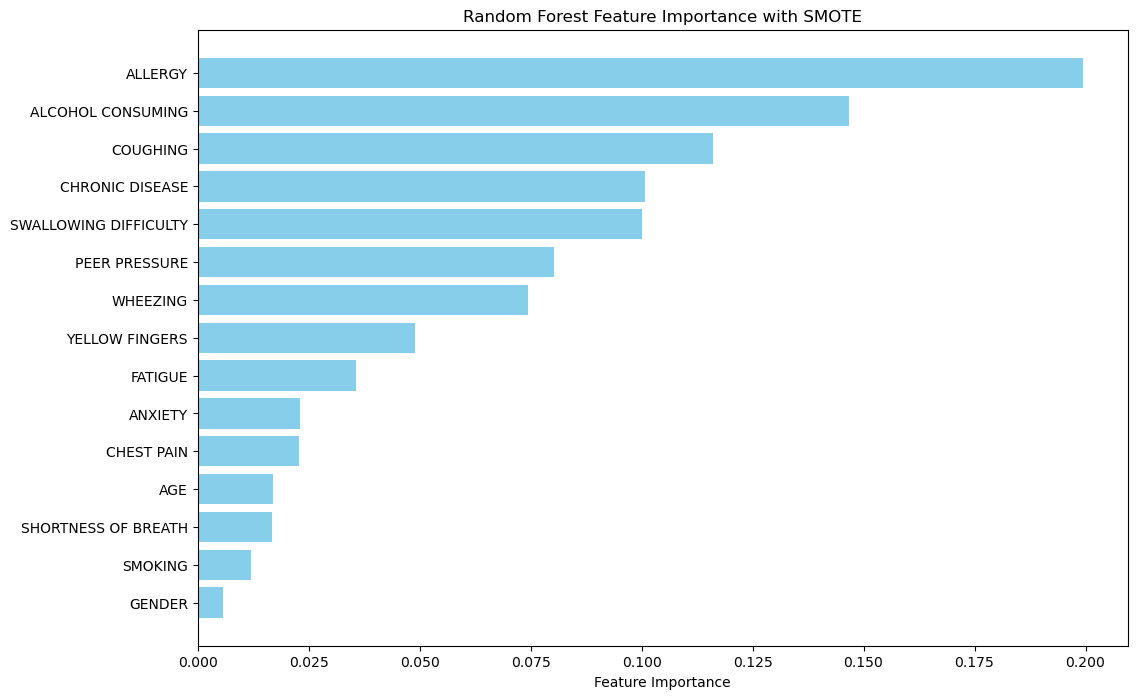

In [119]:
def plot_feature_importance(rf_model, feature_names, title):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(12, 8))
    plt.barh(sorted_feature_names, importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(best_rf_model_without_smote, X.columns, "Random Forest Feature Importance without SMOTE")
plot_feature_importance(best_rf_model_with_smote, X.columns, "Random Forest Feature Importance with SMOTE")

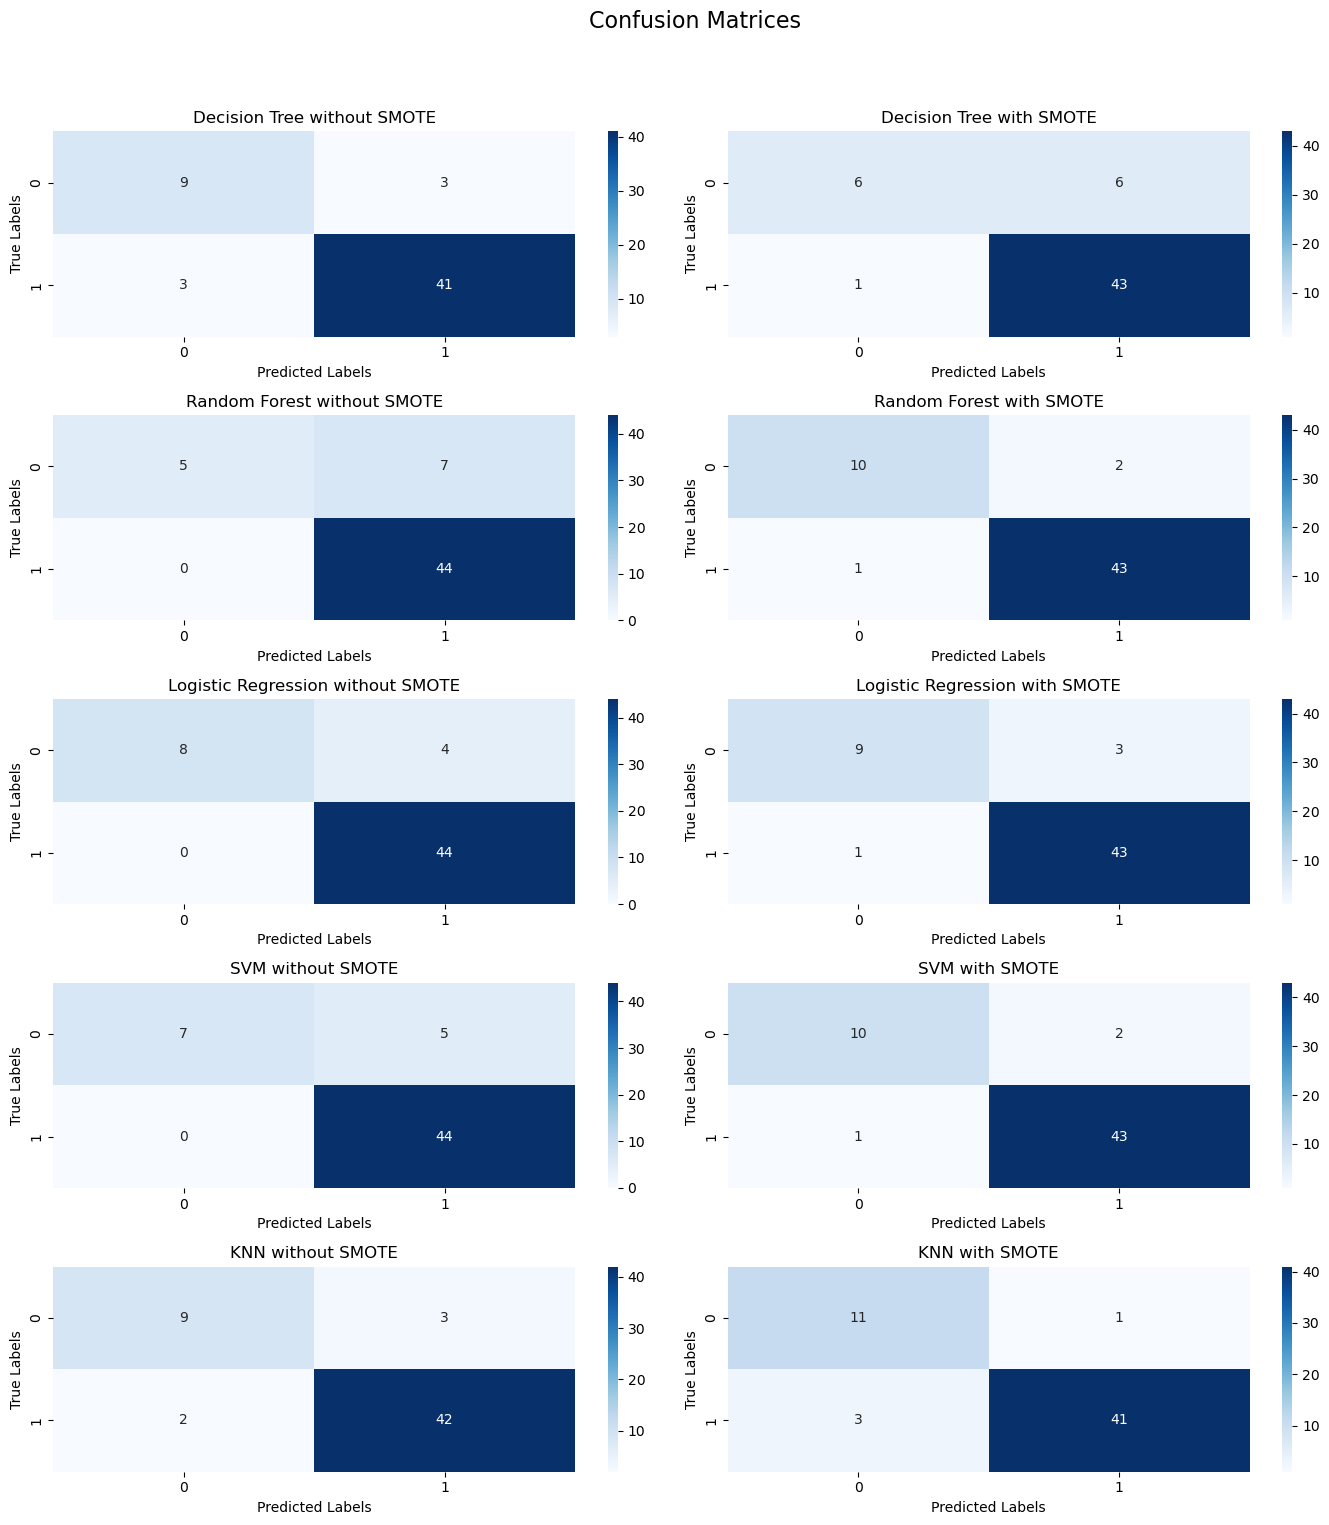

In [120]:
# plot confusion matrices using saved predictions
def plot_confusion_matrices():
    fig, axes = plt.subplots(len(results) // 2, 2, figsize=(14, 16))
    fig.suptitle("Confusion Matrices", fontsize=16)

    for idx, (key, res) in enumerate(results.items()):
        i, j = divmod(idx, 2)
        sns.heatmap(res['conf_matrix'], annot=True, fmt="d", cmap="Blues", ax=axes[i, j])
        axes[i, j].set_title(key)
        axes[i, j].set_xlabel("Predicted Labels")
        axes[i, j].set_ylabel("True Labels")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_confusion_matrices()

In [121]:
def create_results_table():
    # Create a DataFrame from results dictionary
    summary_table = pd.DataFrame.from_dict(results, orient='index')
    
    # Select columns
    summary_table = summary_table[['accuracy', 'precision', 'recall', 'f1_score']]
    
    # display  table
    print("Classification Results Summary:")
    print(summary_table)

create_results_table()

Classification Results Summary:
                                   accuracy  precision    recall  f1_score
Decision Tree without SMOTE        0.892857   0.931818  0.931818  0.931818
Decision Tree with SMOTE           0.875000   0.877551  0.977273  0.924731
Random Forest without SMOTE        0.875000   0.862745  1.000000  0.926316
Random Forest with SMOTE           0.946429   0.955556  0.977273  0.966292
Logistic Regression without SMOTE  0.928571   0.916667  1.000000  0.956522
Logistic Regression with SMOTE     0.928571   0.934783  0.977273  0.955556
SVM without SMOTE                  0.910714   0.897959  1.000000  0.946237
SVM with SMOTE                     0.946429   0.955556  0.977273  0.966292
KNN without SMOTE                  0.910714   0.933333  0.954545  0.943820
KNN with SMOTE                     0.928571   0.976190  0.931818  0.953488
